In [1]:
from eurostat_dataset import eurostat_dataset # packed in class the method to wrangle eurostat's table 
import pandas as pd
import sqlite3
import plotly.express as px
import plotly.offline as pyo
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

# to activate env: venv\Scripts\activate.bat
# python -m pip freeze > requirements.txt




1. Wrangling the data from the Eurostat database.

In [2]:
# uncheck this comment to download dataset to the local sqlite database in the same folder
# eurostat_dataset(code='NRG_BAL_S').WriteToDatabase() #it takes about 8 min downloading
# eurostat_dataset(code='NRG_INF_EPCRW').WriteToDatabase()
# write to a local sqlite database, so you don't need to wait everytime when you restart the kernel or the file

In [3]:
def db_tables():
    """
    Check the tables that has been written to the local database
    Args:
        None
    Returns:
        The list of tables titles in the local sqlite database
    
    """
    con = sqlite3.connect('ngr.db')
    cursor = con.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    print(cursor.fetchall())
    con.close

In [4]:
def read_df_from_db(table):
    """
    Reading the table from db to DataFrame
    Args:
        table(str): The title of one table we get from the list db_tables()
    Returns:
        Dataframe
    
    """
    con = sqlite3.connect('ngr.db')
    cursor = con.cursor()   
    df = pd.read_sql_query("SELECT * FROM "+ table , con)
    con.close
    df.drop(columns=['index'],inplace=True)

    return df

In [5]:
tables = db_tables()
print(f'The list of tables in the local sqlite database {tables}') # we can see the title of tables in the database 'ngr.db'

[('nrg_bal_s',), ('nrg_inf_epcrw',)]
The list of tables in the local sqlite database None


1.1. Getting the dataset info: title, start and end date of the data.

In [6]:
#Use the method DatasetInfo() from eurostat_dataset to get the metadata
renew = eurostat_dataset(code='nrg_inf_epcrw').DatasetInfo()
dataset_info=eurostat_dataset(code='NRG_BAL_S').DatasetInfo()
print(f'The first dataset: "{dataset_info[0]}" dates from {dataset_info[1]} to {dataset_info[2]}.')
print(f'The second dataset: "{renew[0]}" dates from {renew[1]} to {renew[2]}.')

The first dataset: "Simplified energy balances" dates from 1990 to 2020.
The second dataset: "Electricity production capacities for renewables and wastes" dates from 1990 to 2020.


1.2. Final energy consumption by European countries.

In [7]:
#reading the tables from the local database
bal = read_df_from_db('nrg_bal_s')
get_energy = read_df_from_db('nrg_inf_epcrw')


In [8]:
def preprocess_dataset(df):
    """
    Preprocess dataframe

    Args:
        Dataframe of Eurostat dataset that contains value and date columns
        
    Returns:
        Dataframe preprocessed for the futher manipulation
    
    """
    df.value=df.value.astype('str').fillna('').str.extract(r"(\d+)|(\d+)\.")[0].astype('Int32')
    df.date=pd.to_numeric(df.date)
    return df

In [9]:
bal = preprocess_dataset(bal)
get_energy = preprocess_dataset(get_energy)

In [10]:
balance=bal.copy() #without slicing
balance = balance.query('unit=="Gigawatt-hour" and siec=="Total" and nrg_bal=="Final consumption - energy use" \
and geo not in ("Euro area - 19 countries  (from 2015)","European Union - 27 countries (from 2020)")')

Final consumption - energy use (Gigawatt-hour)

In [11]:
balance.head()

,nrg_bal,siec,unit,geo,date,value
5778,Final consumption - energy use,Total,Gigawatt-hour,Albania,2020,21474
5779,Final consumption - energy use,Total,Gigawatt-hour,Austria,2020,288624
5780,Final consumption - energy use,Total,Gigawatt-hour,Bosnia and Herzegovina,2020,46804
5781,Final consumption - energy use,Total,Gigawatt-hour,Belgium,2020,360985
5782,Final consumption - energy use,Total,Gigawatt-hour,Bulgaria,2020,110633


Population

In [12]:
#get population dataset and clean it
pop = eurostat_dataset('TPS00001').GetDf()
population=preprocess_dataset(pop)

In [13]:
#merge with balance tables to have the measure per capita
m_balance = balance.merge(population[["geo","date","value"]],on=['geo',"date"],suffixes=("", "_population"))
m_balance = m_balance.assign(per_capita=lambda x: x.value*1000/x.value_population)

In [14]:
"Gross electricity production"
el_production = bal.query('unit=="Gigawatt-hour" and siec=="Total" and nrg_bal=="Gross electricity production" \
and geo not in ("Euro area - 19 countries  (from 2015)","European Union - 27 countries (from 2020)")')



In [15]:
renewables = bal.query('unit=="Gigawatt-hour" and siec=="Renewables and biofuels" and nrg_bal=="Gross electricity production" \
and geo not in ("Euro area - 19 countries  (from 2015)","European Union - 27 countries (from 2020)")')

2. Energy Consumption, electricity production and electricity production from renewable

 ###### As for Latvia in 2020: 
 ###### - Energy consumption: 44172.893 Gigawatt-hour
 ###### - electricity production - 5724.846 Gigawatt-hour. 13% from Energy consumption
 ###### - electricity production from renewable - 3649.529 Gigawatt-hour. 63% from electricity production
 ###### - 87% electricity production from the Hydro 


In [16]:
def measure_series(df,measure):
    """
    One pandas series for the one measure

    Args:
        Dataframe: Preprocessed Dataframe of Eurostat dataset
        measure (str): the title of measure
        
        
    Returns:
        Named pandas series with the indexes: geo, date for the further concat
    
    """
    return df[['geo','date','value']].rename(columns={'value':measure}).set_index(['geo','date']).squeeze()

In [17]:
#the query to get only aggragated renewables sources from the second table "Electricity production capacities for renewables and wastes"
ren_table = get_energy.query('siec in ("Solid biofuels","Biogases","Hydro","Geothermal","Wind","Solar") \
    and geo not in ("Euro area - 19 countries  (from 2015)","European Union - 27 countries (from 2020)")')

#calculation of relative measures: percentage of the each renewable source from the sum of production
ren_table['perc'] = ren_table['value'] / ren_table.groupby(['geo','date'])['value'].transform('sum')
ren_table['max_perc'] = ren_table.groupby(['geo','date'])['perc'].transform(max)
source_nameSeries = ren_table.query('perc==max_perc')[['geo','date','siec']].drop_duplicates(subset=['geo','date'])\
                        .rename(columns={'siec':'Main Renewable Source'}).set_index(['geo','date']).squeeze()

source_percSeries = ren_table.query('perc==max_perc')[['geo','date','perc']].drop_duplicates(subset=['geo','date'])\
                        .rename(columns={'perc':'Main Renewable Source,perc'}).set_index(['geo','date']).squeeze()


In [18]:
consumptionSeries = measure_series(balance,'Final consumption')
productionSeries = measure_series(el_production,'Electricity production')
renewSeries = measure_series(renewables,'Electricity production from Renewables and biofuels')


In [19]:
#concat the all pandas series,the result - the table with all measures. Non-relative measures in Gigawatt-hour
concated = pd.concat([consumptionSeries,productionSeries,renewSeries,source_nameSeries,source_percSeries],axis=1)
concated['Electricity production from Renewables and biofuels'] = pd.to_numeric(concated['Electricity production from Renewables and biofuels'])
concated["Electricity production from Final consumption,perc"] = concated['Electricity production']/concated['Final consumption']
concated["Electricity production from Renewables and biofuels,perc"] = concated['Electricity production from Renewables and biofuels']/concated['Electricity production'] 
cols = concated.columns.to_list()
new_cols = cols[:5]+cols[7:9]+cols[5:7]
concated = concated[new_cols].reset_index()

In [20]:
concated

,geo,date,Final consumption,Electricity production,Electricity production from Renewables and biofuels,Main Renewable Source,"Main Renewable Source,perc","Electricity production from Final consumption,perc","Electricity production from Renewables and biofuels,perc"
0,Albania,2020,21474,5313,5313,Hydro,0.991279,0.247415,1.0
1,Austria,2020,288624,72556,58779,Hydro,0.700398,0.251386,0.810119
2,Bosnia and Herzegovina,2020,46804,16874,4983,Hydro,0.948523,0.360525,0.295306
3,Belgium,2020,360985,88890,24458,Solar,0.448395,0.246243,0.275149
4,Bulgaria,2020,110633,40731,7977,Hydro,0.646496,0.368163,0.195846
...,...,...,...,...,...,...,...,...,...
1235,Slovakia,1990,161007,26132,2515,NaN,<NA>,0.162304,0.096242
1236,Türkiye,1990,438615,57543,23228,Hydro,0.997346,0.131193,0.403663
1237,Ukraine,1990,1671235,298835,10723,NaN,<NA>,0.178811,0.035883
1238,United Kingdom,1990,1474621,319737,7793,Hydro,0.974981,0.216827,0.024373


Plots

In [21]:
df_plot = concated[concated.date==2020].dropna()

In [22]:
df_plot.loc[df_plot.geo=='Kosovo (under United Nations Security Council Resolution 1244/99)','geo'] = 'Kosovo'
df_plot.loc[df_plot.geo=='Germany (until 1990 former territory of the FRG)','geo'] = 'Germany'

Text(0.5, 0.98, 'Final consumption,Electricity production and Electricity production from Renewables and biofuels, Gigawatt-hour')

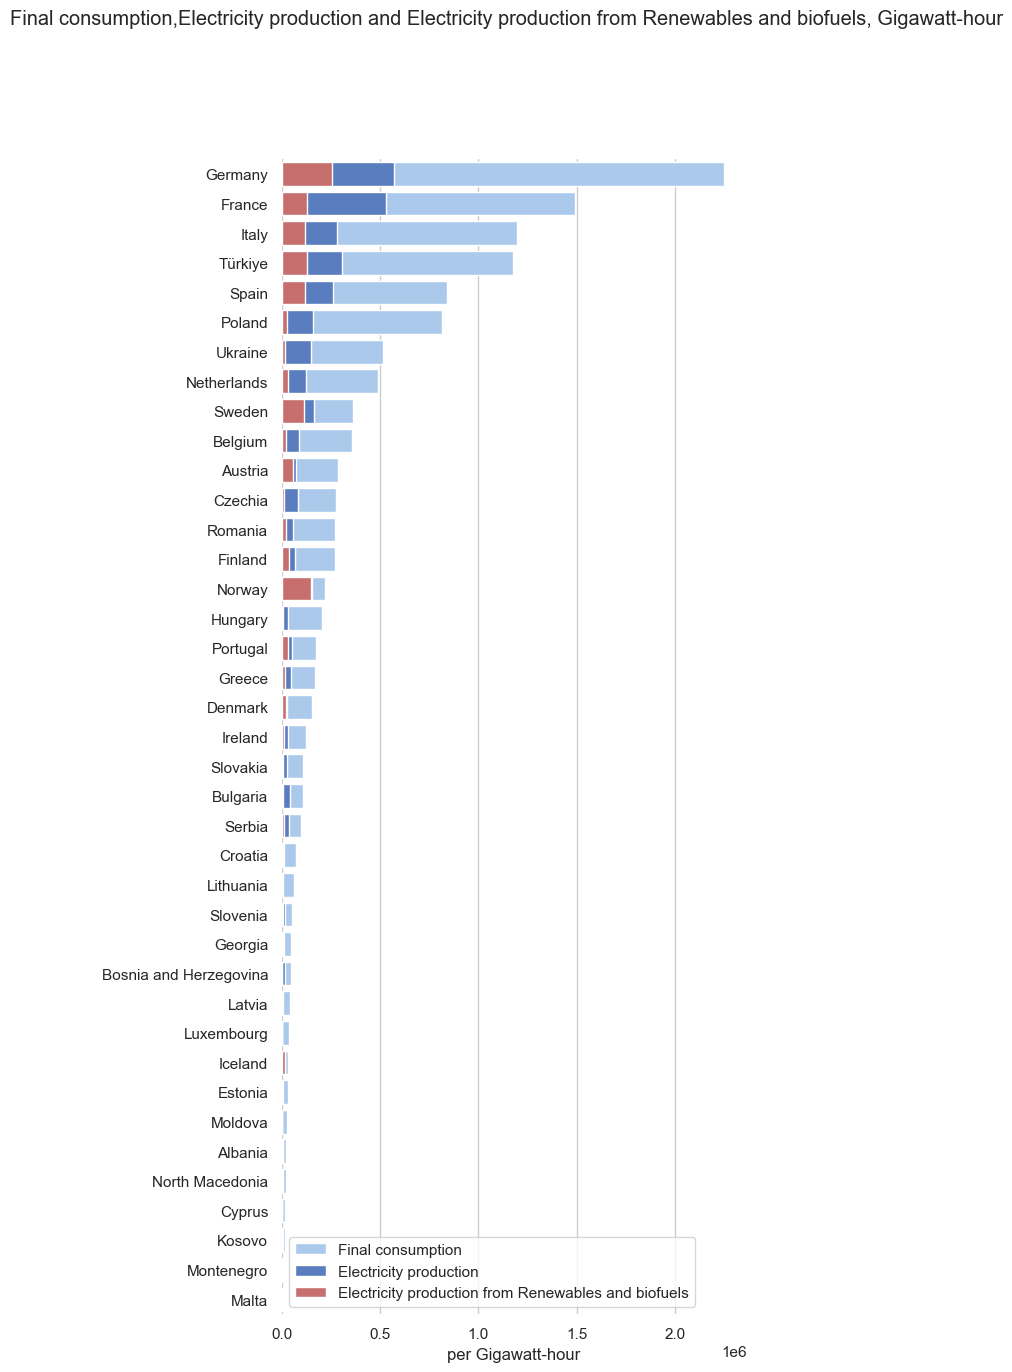

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
consumption = df_plot.sort_values("Final consumption", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Final consumption", y="geo", data=consumption,
            label="Final consumption", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="Electricity production", y="geo", data=consumption,
            label="Electricity production", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="Electricity production from Renewables and biofuels", y="geo", data=consumption,
            label="Electricity production from Renewables and biofuels", color="r")

# Add a legend and informative axis label
ax.legend(ncol=1,  frameon=True)
ax.set( ylabel="",
       xlabel="per Gigawatt-hour")
sns.despine(left=True, bottom=True)

f.suptitle("Final consumption,Electricity production and Electricity production from Renewables and biofuels, Gigawatt-hour")


In [24]:
def plot_measure(df_plot2,measure):
    sns.set_theme(style="dark")

    df_plot2 = df_plot2.dropna()
    df_plot2.loc[df_plot2.geo=='Kosovo (under United Nations Security Council Resolution 1244/99)','geo'] = 'Kosovo'
    df_plot2.loc[df_plot2.geo=='Germany (until 1990 former territory of the FRG)','geo'] = 'Germany'

    # Plot each year's time series in its own facet
    g = sns.relplot(
        data=df_plot2,
        x="date", y=measure, col="geo", #hue="date",
        kind="line", palette="crest", linewidth=4, zorder=5,
        col_wrap=4, height=2, aspect=1.5, legend=False
    )

    # Iterate over each subplot to customize further
    for geo, ax in g.axes_dict.items():

        # Add the title as an annotation within the plot
        ax.text(.8, .85, geo, transform=ax.transAxes, fontweight="bold")

        # Plot every year's time series in the background
        sns.lineplot(
            data=df_plot2, x="date", y=measure, units="geo",
            estimator=None, color=".7", linewidth=1, ax=ax,
        )

    # Reduce the frequency of the x axis ticks
    # ax.set_xticks(ax.get_xticks()[::2])

    # Tweak the supporting aspects of the plot
    g.set_titles(" ")
    g.set_axis_labels("", "")
    # g.tight_layout()
    g.figure.suptitle(measure)
    return g



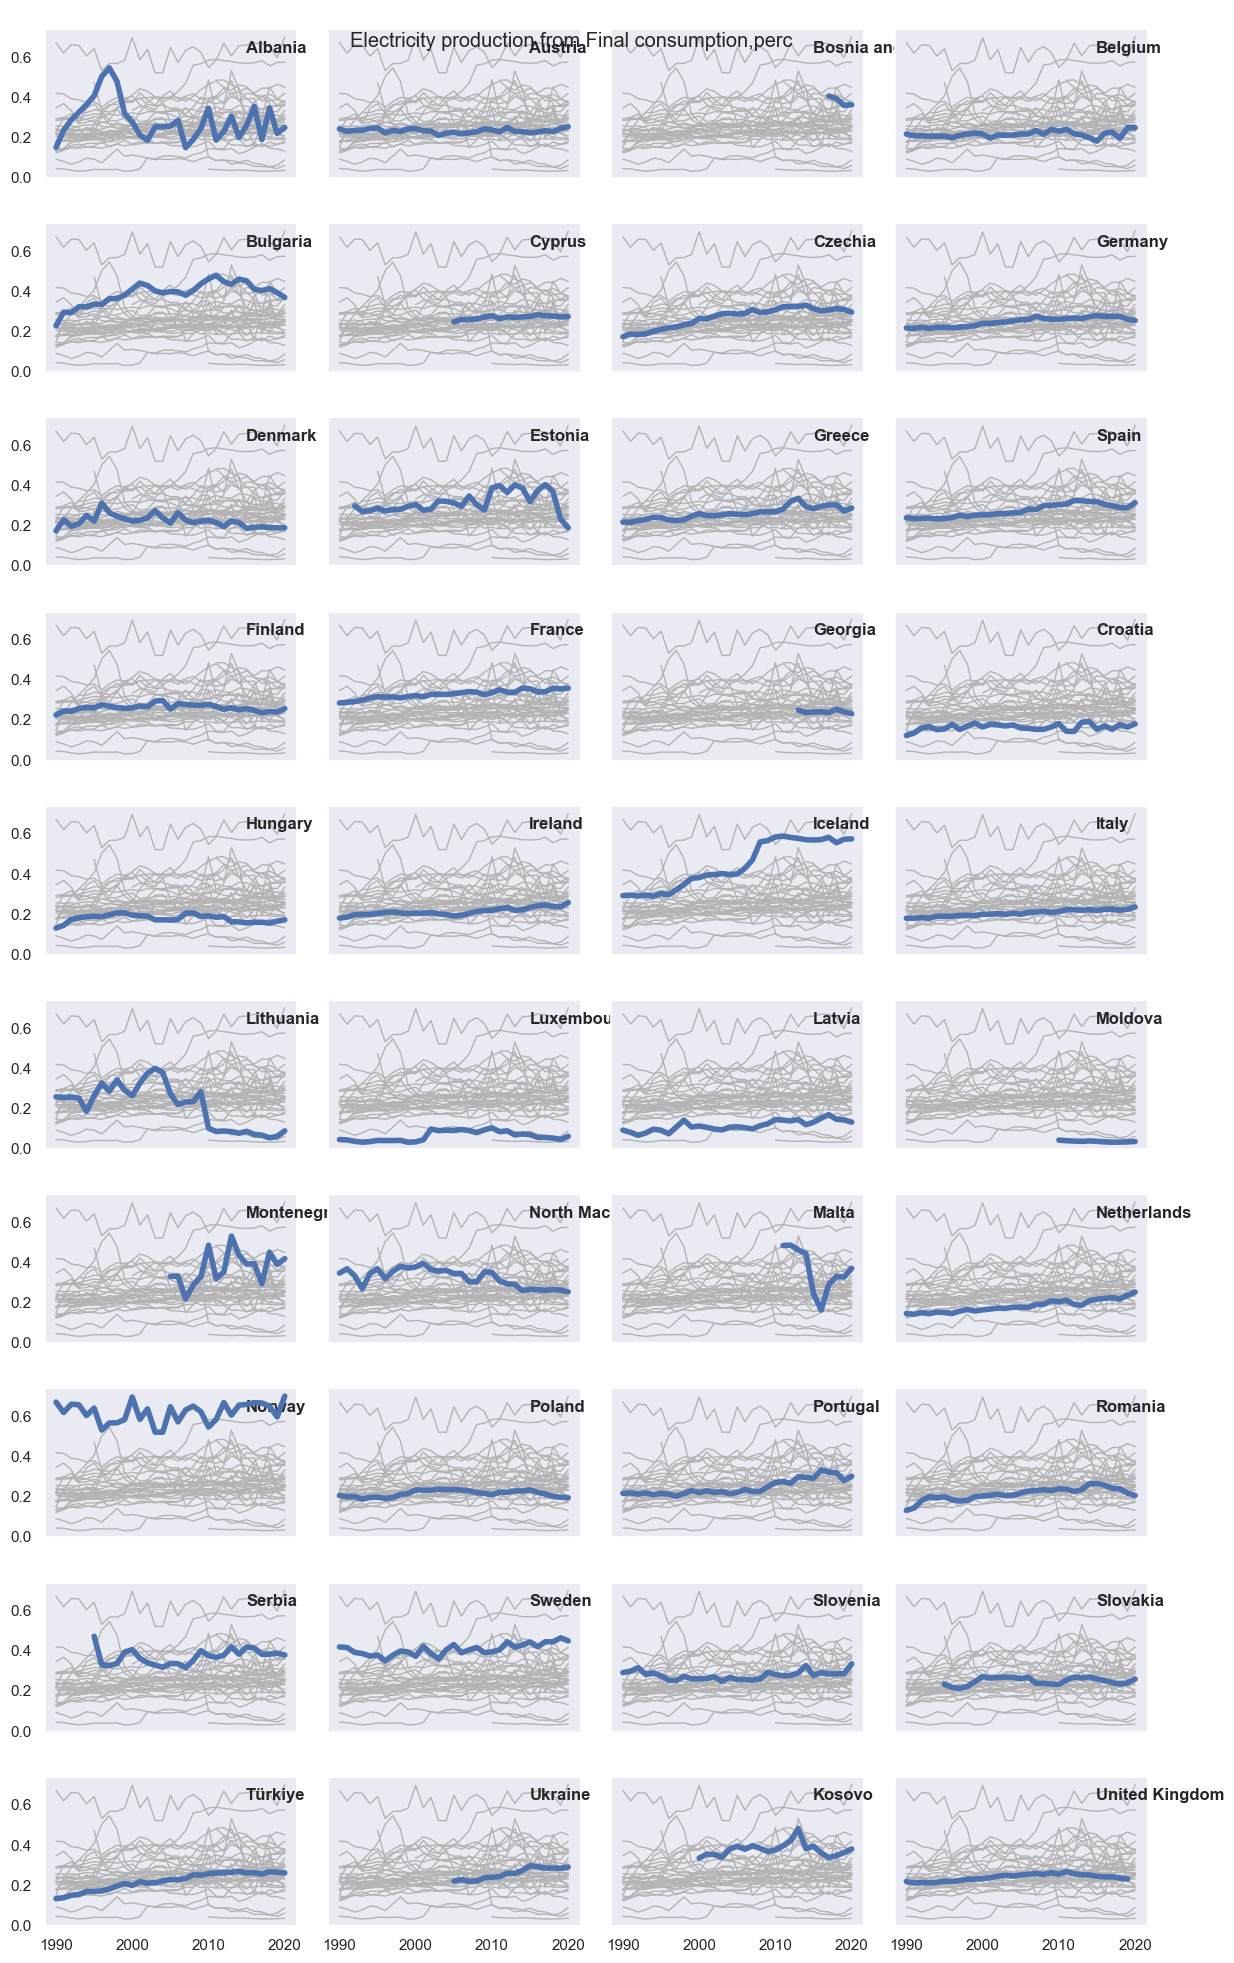

In [25]:
plot_measure(concated,'Electricity production from Final consumption,perc')

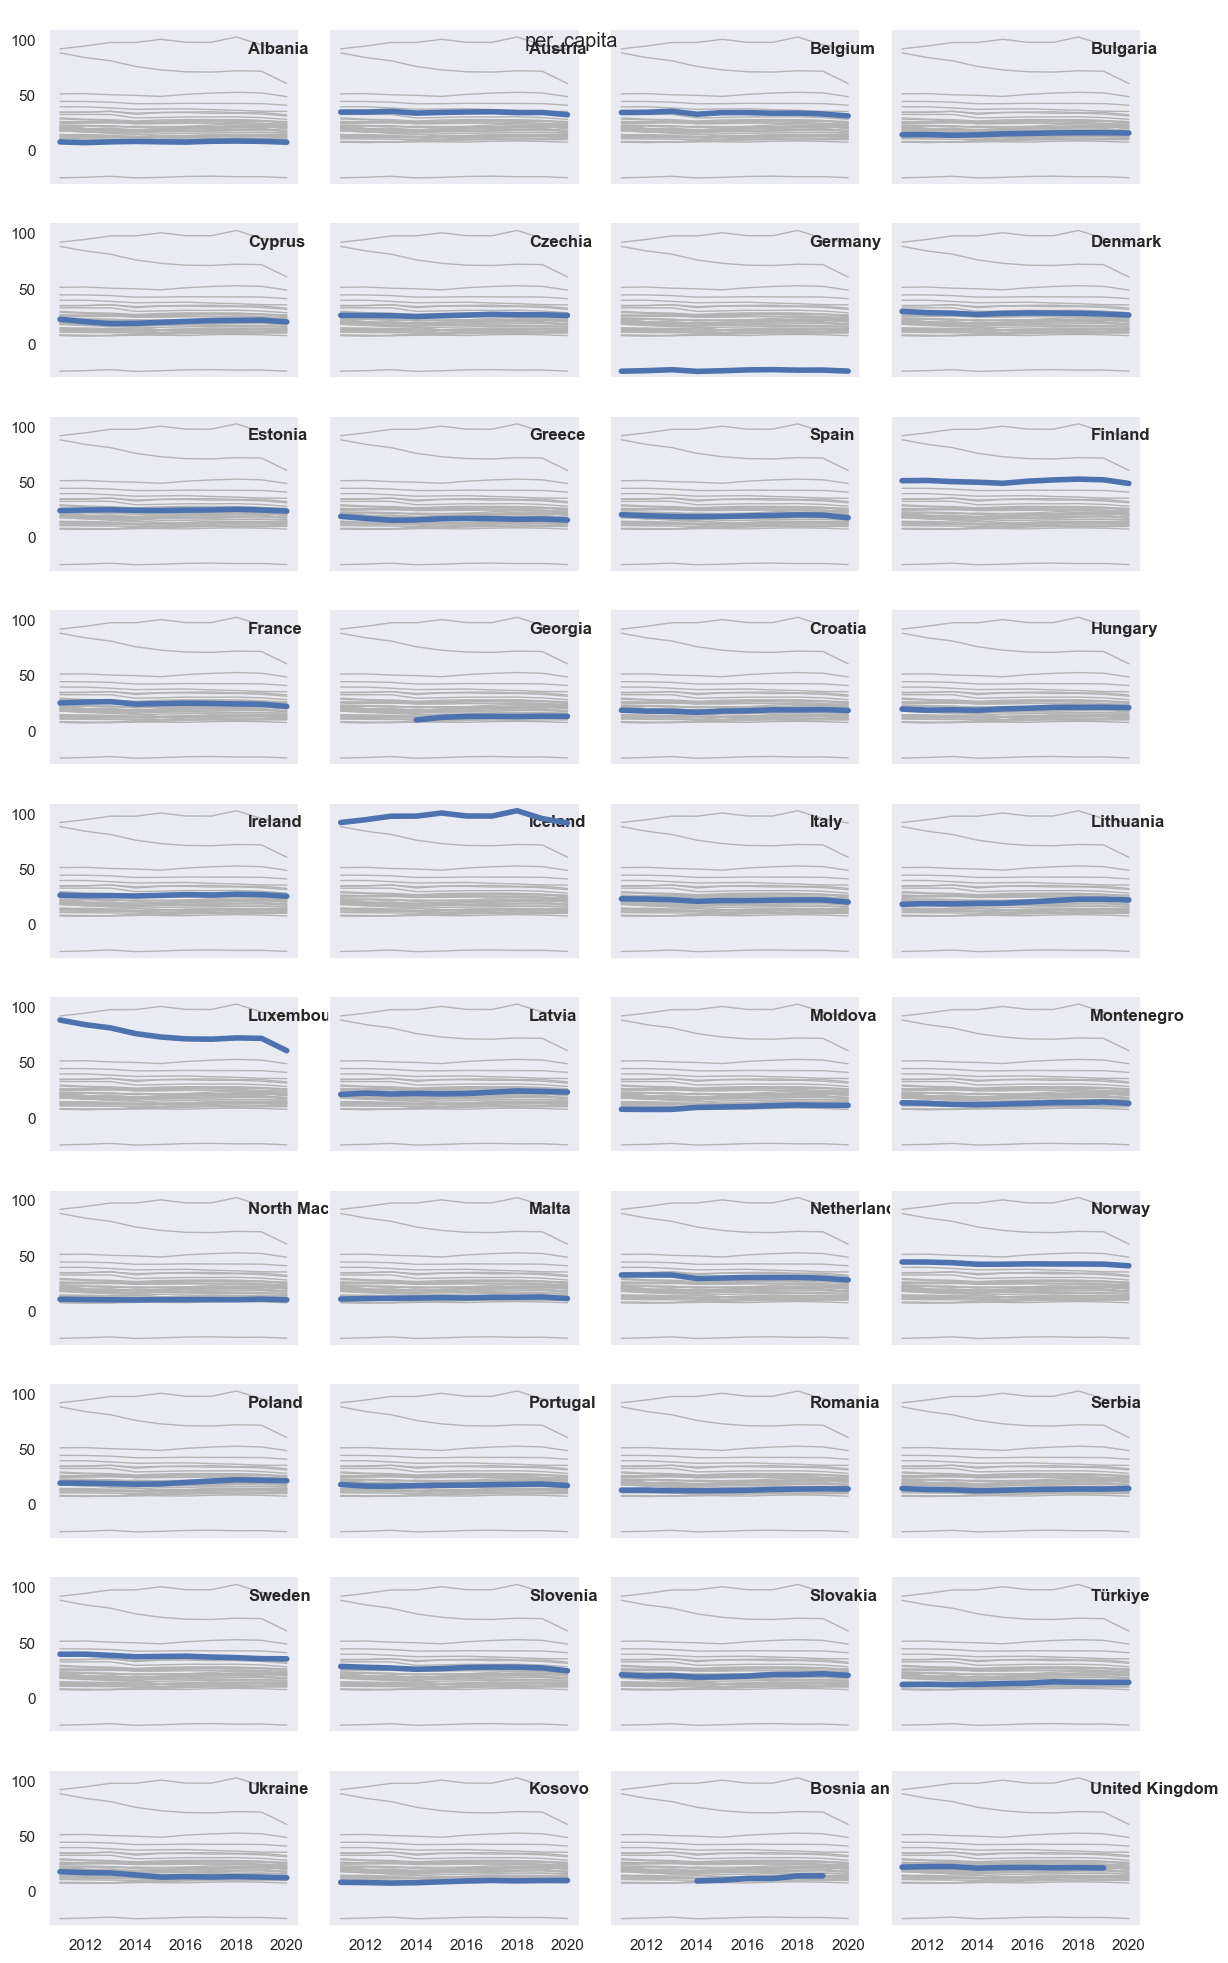

In [26]:
#Energy consamption per capita,Megawatt-hour
plot_measure(m_balance,'per_capita')